**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS4487 - Tutorial 9
## Face Detection with CNNs

In this tutorial you will train a CNN to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

//anaconda/envs/keras2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/keras2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
//anaconda/envs/keras2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20

Next we will load keras and tensorflow (or Theano).
If you are using the lab PCs, then you need to use Theano. Also make sure to set the backend of Keras to use Theano.  See [here](https://keras.io/backend/#switching-from-one-backend-to-another).

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
import keras

# select as appropriate
import tensorflow
# import theano

import logging
logging.basicConfig()
import struct

## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the images.

In [3]:
filelist = glob.glob('faces/*/*/*.png')

if len(filelist) == 0:
    warn.error("Could not find images in faces directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = {'train':[], 'test':[]}
    classes = {'train':[], 'test':[]}

    for f in filelist:
        # read image: range is [0,1]
        img = skimage.io.imread(f)
        # convert to grayscale
        img = skimage.color.rgb2gray(img)

        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(f)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        imgdata[fset].append(img)
        classes[fset].append(myclass)
    imgsize = img.shape

    
# remove some non-face test cases to balance the test set
testclass2start = sum(classes['test'])
imgdata['test']  = imgdata['test'][:2*testclass2start]
classes['test']  = classes['test'][:2*testclass2start]

Next we will convert the list of images into a block (array) of images for easier processing.

In [4]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.np_utils.to_categorical(trainY)
testYb  = keras.utils.np_utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,1,19,19))
testI  = asarray(imgdata['test']).reshape((944,1,19,19))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print trainI.shape
print testI.shape

(6977, 1, 19, 19)
(944, 1, 19, 19)


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


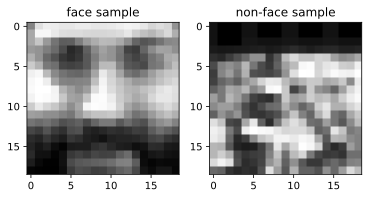

In [5]:
print img.shape
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

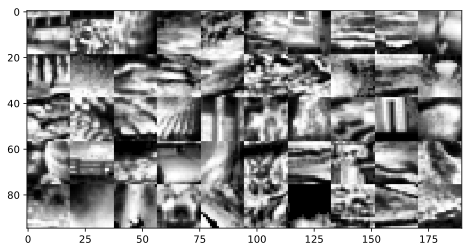

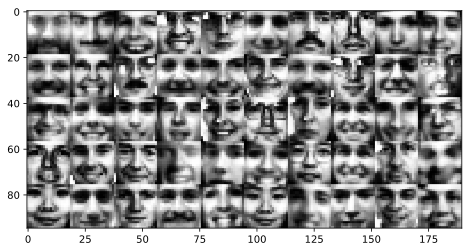

In [6]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, basestring):
                    plt.title(titles % idx)
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [7]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  cross_validation.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print vtrainI.shape
print validI.shape

(6279, 1, 19, 19)
(698, 1, 19, 19)


Here are some useful functions.

In [8]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss (%g)" % history.history['loss'][-1])
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss (%g)" % history.history['val_loss'][-1])
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc (%g)" % history.history['acc'][-1])
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc (%g)" % history.history['val_acc'][-1])

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

## 2. Detection using NN

Train a CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, weight decay, and dropout rate to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [10]:
### INSERT YOUR CODE HERE



In [11]:
### For comparison, here are some MLPs ###


In [9]:
# Reshape the images to a vector (data is already [0,1])
trainX = trainI.reshape((len(trainI), -1), order='C')
testX = testI.reshape((len(testI), -1), order='C')

print trainX.shape
print testX.shape

# generate a fixed validation set using 10% of the training set
vtrainX, validX, vtrainYb, validYb = \
  cross_validation.train_test_split(trainX, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# validation data
validset  = (validX, validYb)

(6977, 361)
(944, 361)


Epoch 00013: early stopping
test accuracy: 0.610169491525


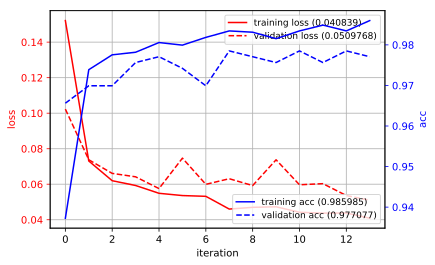

In [11]:
## Logistic regression 

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=2, input_dim=361, activation='softmax'))

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_acc',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 00014: early stopping
test accuracy: 0.665254237288


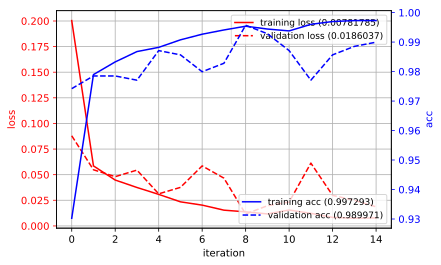

In [16]:
# MLP: 200 - 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=200, input_dim=361, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

plot_history(history)
predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 00013: early stopping
test accuracy: 0.656779661017


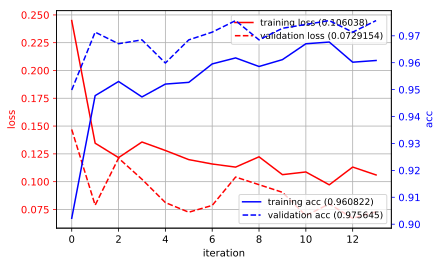

In [51]:
# MLP: 200 - Dropout - 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=200, input_dim=361, activation='relu'))
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

plot_history(history)
predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 00032: early stopping
test accuracy: 0.613347457627


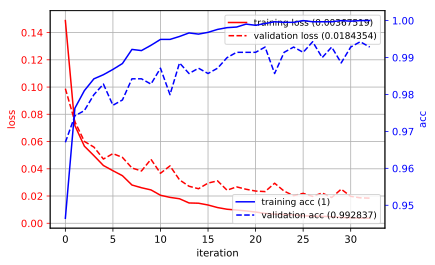

In [17]:
# MLP: 1000 -> 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=1000, input_dim=361, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

plot_history(history)
predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 00025: early stopping
test accuracy: 0.626059322034


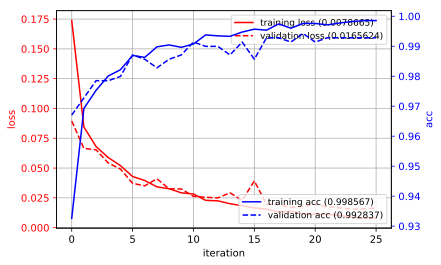

In [18]:
# MLP: 1000 -> Dropout -> 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=1000, input_dim=361, activation='relu'))
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

plot_history(history)
predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

In [ ]:
### now some CNNs #########################

Epoch 00017: early stopping
test accuracy: 0.629237288136


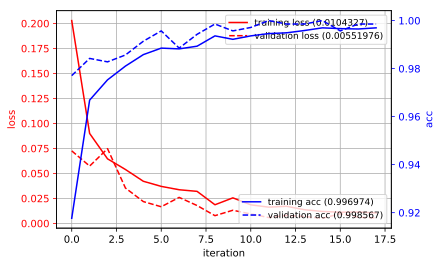

In [50]:
# conv(20,5x5) - Dropout - 50 - Dropout - 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(20, (5,5),        # channel, kerne size
              strides=(1,1),    # stride
              activation='relu',
              padding='same',   # convolution padding
              data_format='channels_first', # using channel-first format              
              input_shape=(1,19,19),
              kernel_regularizer=keras.regularizers.l2(0.0001)
       ))
nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=50, activation='relu', 
      ))
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=2, activation='softmax', 
            ))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 00030: early stopping
test accuracy: 0.753177966102


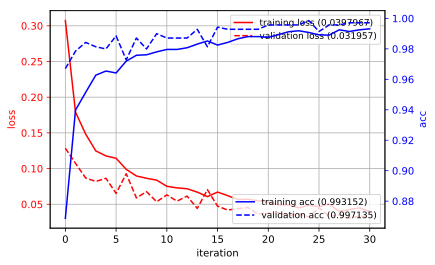

In [49]:
# conv(10,5x5) - Dropout - conv(20,3x3) - Dropout - 100 - 2

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

_How does the CNN compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**
- It's a bit worse.  SVM-poly was 0.814 accuracy, compared to 0.753 for NN.

## 3. Data Augmentation

Augmenting the training data with permutations is a good way to prevent NN from overfitting, and improving their generalization.  We will use the built-in `ImageDataGenerator` to apply geometric transformations.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [83]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [88]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

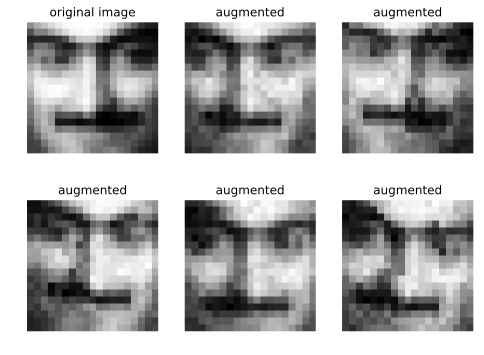

In [89]:
img = trainI[4]
imgs = [img[0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,1,19,19), [1], batch_size=1):
    imgs.append(augimg[0,0,:,:])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

Train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [90]:
### INSERT YOUR CODE HERE ###

In [ ]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

Epoch 1/100
125/125 [==============================] - 8s - loss: 0.5108 - acc: 0.7634 - val_loss: 0.2601 - val_acc: 0.9097
Epoch 2/100
125/125 [==============================] - 7s - loss: 0.3742 - acc: 0.8449 - val_loss: 0.2505 - val_acc: 0.8997
Epoch 3/100
125/125 [==============================] - 8s - loss: 0.3151 - acc: 0.8725 - val_loss: 0.2419 - val_acc: 0.9126
Epoch 4/100
125/125 [==============================] - 7s - loss: 0.3026 - acc: 0.8819 - val_loss: 0.2085 - val_acc: 0.9226
Epoch 5/100
125/125 [==============================] - 7s - loss: 0.2844 - acc: 0.8861 - val_loss: 0.2098 - val_acc: 0.9241
Epoch 6/100
125/125 [==============================] - 7s - loss: 0.2744 - acc: 0.8981 - val_loss: 0.1943 - val_acc: 0.9341
Epoch 7/100
125/125 [==============================] - 8s - loss: 0.2625 - acc: 0.9011 - val_loss: 0.2176 - val_acc: 0.9212
Epoch 8/100
125/125 [==============================] - 9s - loss: 0.2651 - acc: 0.9036 - val_loss: 0.1941 - val_acc: 0.9284
Epoch 9/

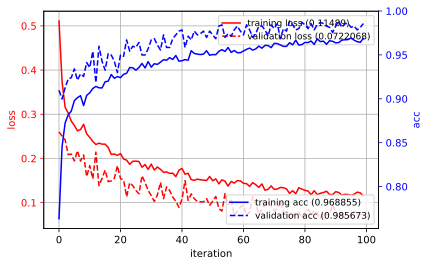

In [106]:
# original augmenter

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])


history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
#            callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 1/100
125/125 [==============================] - 7s - loss: 0.4646 - acc: 0.7870 - val_loss: 0.2286 - val_acc: 0.9212
Epoch 2/100
125/125 [==============================] - 5s - loss: 0.3229 - acc: 0.8741 - val_loss: 0.2494 - val_acc: 0.9155
Epoch 3/100
125/125 [==============================] - 9s - loss: 0.2781 - acc: 0.8959 - val_loss: 0.2185 - val_acc: 0.9198
Epoch 4/100
125/125 [==============================] - 6s - loss: 0.2553 - acc: 0.9077 - val_loss: 0.2010 - val_acc: 0.9298
Epoch 5/100
125/125 [==============================] - 6s - loss: 0.2503 - acc: 0.9069 - val_loss: 0.1799 - val_acc: 0.9384
Epoch 6/100
125/125 [==============================] - 5s - loss: 0.2428 - acc: 0.9104 - val_loss: 0.1722 - val_acc: 0.9470
Epoch 7/100
125/125 [==============================] - 5s - loss: 0.2326 - acc: 0.9140 - val_loss: 0.1997 - val_acc: 0.9284
Epoch 8/100
125/125 [==============================] - 5s - loss: 0.2373 - acc: 0.9133 - val_loss: 0.1648 - val_acc: 0.9384
Epoch 9/

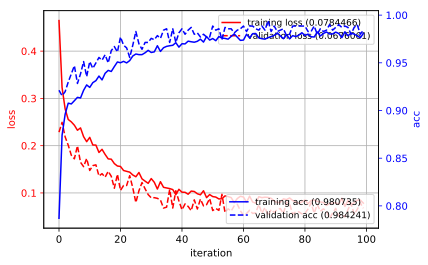

In [109]:
# increase range of shifting, shear, zoom

# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])


history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            validation_data=validsetI, verbose=True)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 1/100
125/125 [==============================] - 8s - loss: 0.5106 - acc: 0.7616 - val_loss: 0.2504 - val_acc: 0.9155
Epoch 2/100
125/125 [==============================] - 6s - loss: 0.3699 - acc: 0.8480 - val_loss: 0.2521 - val_acc: 0.9040
Epoch 3/100
125/125 [==============================] - 5s - loss: 0.3093 - acc: 0.8784 - val_loss: 0.2496 - val_acc: 0.9140
Epoch 4/100
125/125 [==============================] - 5s - loss: 0.2986 - acc: 0.8805 - val_loss: 0.1950 - val_acc: 0.9284
Epoch 5/100
125/125 [==============================] - 5s - loss: 0.2822 - acc: 0.8885 - val_loss: 0.2216 - val_acc: 0.9212
Epoch 6/100
125/125 [==============================] - 6s - loss: 0.2707 - acc: 0.9028 - val_loss: 0.2089 - val_acc: 0.9255
Epoch 7/100
125/125 [==============================] - 7s - loss: 0.2504 - acc: 0.9073 - val_loss: 0.2160 - val_acc: 0.9212
Epoch 8/100
125/125 [==============================] - 7s - loss: 0.2630 - acc: 0.9038 - val_loss: 0.1717 - val_acc: 0.9398
Epoch 9/

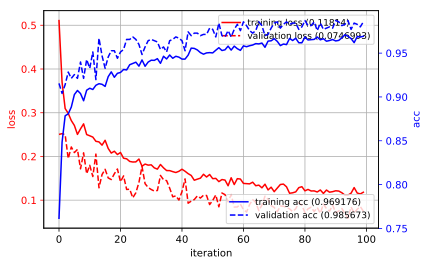

In [94]:
# also add scale_shift noise

# build the noise function
def addNoise(X):
    return add_scale_shift(add_gauss_noise(X, 0.04))

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])


history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            #callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 1/100
125/125 [==============================] - 10s - loss: 0.4850 - acc: 0.7784 - val_loss: 0.2406 - val_acc: 0.9212
Epoch 2/100
125/125 [==============================] - 8s - loss: 0.3429 - acc: 0.8669 - val_loss: 0.2030 - val_acc: 0.9212
Epoch 3/100
125/125 [==============================] - 7s - loss: 0.3131 - acc: 0.8787 - val_loss: 0.2296 - val_acc: 0.9226
Epoch 4/100
125/125 [==============================] - 9s - loss: 0.2806 - acc: 0.8944 - val_loss: 0.1898 - val_acc: 0.9355
Epoch 5/100
125/125 [==============================] - 8s - loss: 0.2771 - acc: 0.8956 - val_loss: 0.2257 - val_acc: 0.9198
Epoch 6/100
125/125 [==============================] - 6s - loss: 0.2623 - acc: 0.9002 - val_loss: 0.2379 - val_acc: 0.9155
Epoch 7/100
125/125 [==============================] - 6s - loss: 0.2614 - acc: 0.9031 - val_loss: 0.1992 - val_acc: 0.9284
Epoch 8/100
125/125 [==============================] - 6s - loss: 0.2530 - acc: 0.9061 - val_loss: 0.2228 - val_acc: 0.9198
Epoch 9

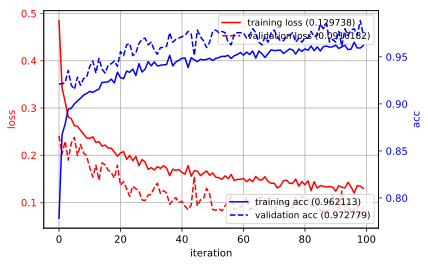

In [110]:
# increase range of shifting, shear, zoom

# build the noise function
def addNoise(X):
    return add_corrupt_noise(add_gauss_noise(X, 0.04))

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])


history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            validation_data=validsetI, verbose=True)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

Epoch 1/100
125/125 [==============================] - 6s - loss: 0.4701 - acc: 0.7834 - val_loss: 0.2335 - val_acc: 0.9140
Epoch 2/100
125/125 [==============================] - 5s - loss: 0.3259 - acc: 0.8718 - val_loss: 0.2580 - val_acc: 0.9198
Epoch 3/100
125/125 [==============================] - 5s - loss: 0.2822 - acc: 0.8962 - val_loss: 0.2192 - val_acc: 0.9198
Epoch 4/100
125/125 [==============================] - 5s - loss: 0.2629 - acc: 0.9023 - val_loss: 0.2013 - val_acc: 0.9284
Epoch 5/100
125/125 [==============================] - 5s - loss: 0.2634 - acc: 0.9037 - val_loss: 0.1876 - val_acc: 0.9398
Epoch 6/100
125/125 [==============================] - 6s - loss: 0.2498 - acc: 0.9064 - val_loss: 0.1801 - val_acc: 0.9370
Epoch 7/100
125/125 [==============================] - 5s - loss: 0.2423 - acc: 0.9091 - val_loss: 0.2082 - val_acc: 0.9284
Epoch 8/100
125/125 [==============================] - 5s - loss: 0.2399 - acc: 0.9098 - val_loss: 0.1737 - val_acc: 0.9384
Epoch 9/

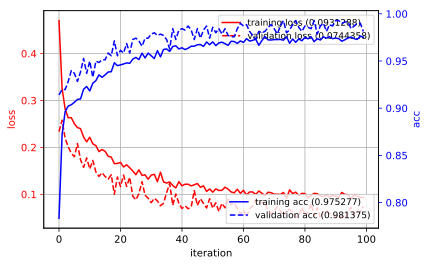

In [111]:
# increase range of shifting, shear, zoom

# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.1)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',  data_format='channels_first',
              input_shape=(1,19,19),
       ))
nn.add(Dropout(rate=0.5))
nn.add(Conv2D(20, (3,3),        # channel, kerne size
              strides=(1,1),    # stride
              kernel_regularizer=keras.regularizers.l2(0.0001),
              activation='relu', padding='same',
              data_format='channels_first' # using channel-first format              
       ))

nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dropout(rate=0.5))
nn.add(Dense(units=100, activation='relu', 
              kernel_regularizer=keras.regularizers.l2(0.0001)
      ))
nn.add(Dense(units=2, activation='softmax',               
             kernel_regularizer=keras.regularizers.l2(0.0001)))
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])


history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            validation_data=validsetI, verbose=True)

plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print "test accuracy: " + str(acc)

_Which type of augmentation improves the accuracy the most?  Why?  How does NN with data augmentation compare with your work in Tutorial 4?_ 
- ** INSERT YOUR ANSWER HERE **
- transformations, gaussian noise, scale+shift
- make the NN invariant to all these transformations
- Now accuracy is 0.91, which is better than SVM-poly from Tutorial 4.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [95]:
fname = "nasa-small.png"

(210, 480)


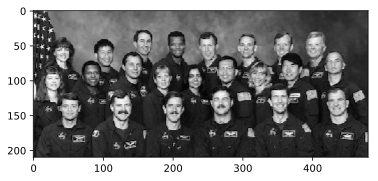

In [96]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print testimg.shape
plt.imshow(testimg, cmap='gray')

In [100]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], 1, psize[2], psize[3]))
print patches2.shape 

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 1, 19, 19)


Now predict using your classifier.  The extracted images are in `newI`.

In [103]:
### YOUR CODE HERE
prednewY = nn.predict_classes(newI)

5504/5568 [============================>.] - ETA: 0s

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

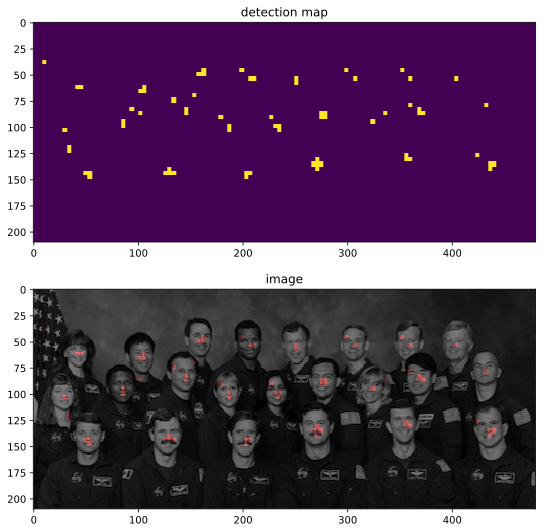

In [105]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- INSERT YOUR ANSWER HERE
- got all the faces, and FP are less than before

- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/8 of the training data. Try using more data to train it!